## 環境設定


In [1]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
import daft
import seaborn as sns
from matplotlib import rc
%matplotlib inline


## データのダウンロード
MNISTのデータをkerasのサイトからダウンロードします。

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

Using TensorFlow backend.


(60000, 784)
(10000, 784)


In [3]:
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import metrics
from keras import backend as K

## 教師付きVAE
教師付きデータでVAEを学習させ、潜在変数の分布から指定したカテゴリの画像の復元をします。

In [4]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
n_x = x_train.shape[1]
n_y = y_train.shape[1]

In [5]:
batch_size = 100
original_dim = 28*28
latent_dim = 20
intermediate_dim = 512
epochs = 150
categorical_dim = 10
epsilon_std = 1.0

In [6]:
# encoding
x = Input(shape=(n_x,))
label = Input(shape=(n_y,))
input = concatenate([x, label] , axis=-1)
h = Dense(intermediate_dim, activation='relu', activity_regularizer = 'l2')(input)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [7]:
def normal_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [8]:
z = Lambda(normal_sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
zc = concatenate([z, label] , axis=-1)

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(zc)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
# end-to-end autoencoder
cvae = Model([x, label], x_decoded_mean)

In [10]:
# encoder, from inputs to latent space
encoder = Model([x, label], z_mean)

In [11]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim+categorical_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [12]:
def normal_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [13]:
def cvae_loss(x, x_decoded_mean):
    recon_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    return K.mean(recon_loss + kl_loss )

In [14]:
cvae.compile(optimizer='rmsprop', loss=cvae_loss)

history = cvae.fit([x_train, y_train], x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, y_test], x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 24s - loss: 165.8565 - val_loss: 136.2912
Epoch 2/150
60000/60000 [==============================] - 24s - loss: 131.1071 - val_loss: 127.8767
Epoch 3/150
60000/60000 [==============================] - 24s - loss: 122.3535 - val_loss: 118.4269
Epoch 4/150
60000/60000 [==============================] - 24s - loss: 117.8729 - val_loss: 115.6204
Epoch 5/150
60000/60000 [==============================] - 25s - loss: 115.1012 - val_loss: 113.2396
Epoch 6/150
60000/60000 [==============================] - 24s - loss: 113.2657 - val_loss: 111.4246
Epoch 7/150
60000/60000 [==============================] - 24s - loss: 112.0224 - val_loss: 110.4420
Epoch 8/150
60000/60000 [==============================] - 24s - loss: 111.0929 - val_loss: 109.7930
Epoch 9/150
60000/60000 [==============================] - 24s - loss: 110.3146 - val_loss: 109.3293
Epoch 10/150
60000/60000 [===============

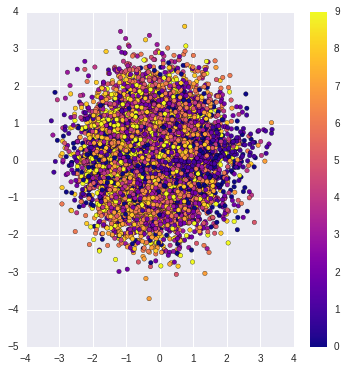

In [15]:
x_test_encoded = encoder.predict([x_test, y_test], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=np.argmax(y_test, axis=1), cmap="plasma")
plt.colorbar()
plt.show()

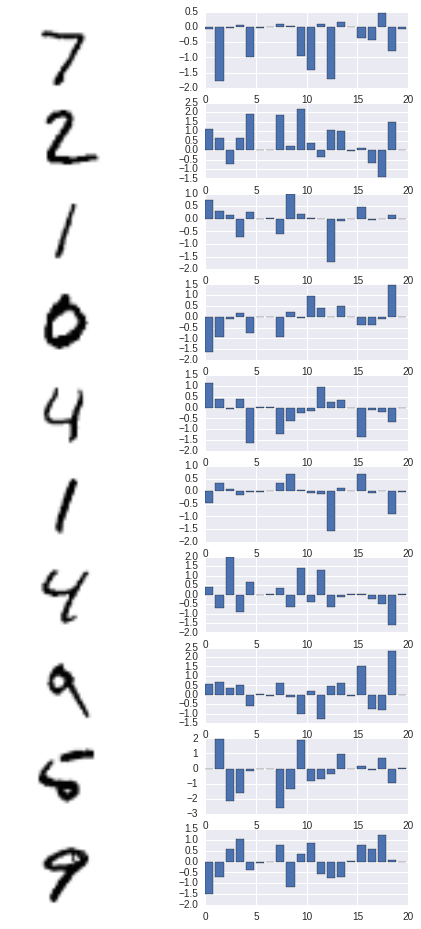

In [16]:
plt.figure(figsize=(8, 16))

n = 10
im_index = 1
indies = range(latent_dim)

for i in range(0, n):
    plt.subplot(n, 2, im_index)
    plt.axis('off')
    plt.imshow(x_test[i].reshape((28,28)))
    im_index += 1

    plt.subplot(n, 2, im_index)
    ax = plt.bar(indies, x_test_encoded[i])
    im_index += 1
plt.show()

In [17]:
def get_one_hot_vector(idx, dim=10):
    one_hot = np.zeros(dim)
    one_hot[idx] = 1.
    return one_hot

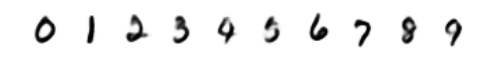

In [18]:
z_predict = encoder.predict([x_test[3].reshape((1, 784)), y_test[3].reshape((1, 10))])
n = 1

plt.figure(figsize=(8, 8))
for j in range(10):
    plt.subplot(1, 10, n); n += 1; plt.axis('off')
    _c_sample = get_one_hot_vector(j, categorical_dim)
    latent_sample = np.hstack((z_predict[0], _c_sample))
    generated = generator.predict(np.array([latent_sample]))
    digit = generated[0].reshape(28, 28)
    plt.imshow(digit)

plt.show()

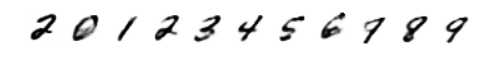

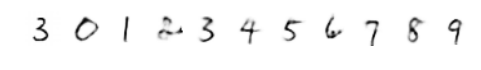

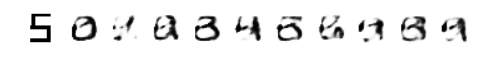

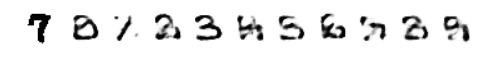

In [19]:
from keras.preprocessing import image

categories = [2, 3, 5, 7]
images = [ "images/%d.png" % i for i in categories]

for i in categories:
    img_path = "images/%d.png" % i
    img = image.load_img(img_path, target_size=(28, 28))  # Read the image and resize it
    
    x_data = x_data = ((255 - image.img_to_array(img))/255)[:, :, 0].reshape((1, 784))
    c_data = get_one_hot_vector(i, categorical_dim).reshape((1, 10))
    z_predict = encoder.predict([x_data, c_data])
    # print z_predict
    n = 1

    plt.figure(figsize=(8, 8))
    plt.subplot(len(categories), 11, n); n += 1; plt.axis('off')
    plt.imshow(img)
    for j in range(10):
        plt.subplot(len(categories), 11, n); n += 1; plt.axis('off')
        _c_sample = get_one_hot_vector(j, categorical_dim)
        latent_sample = np.hstack((z_predict[0], _c_sample))
        generated = generator.predict(np.array([latent_sample]))
        digit = generated[0].reshape(28, 28)
        plt.imshow(digit)

plt.show()